# Validação de modelos

- Validação cruzada
- Validação cruzada com dobras

In [1]:
using Random
using Statistics
using LinearAlgebra
using Plots
theme(:ggplot2)

## Validação cruzada

- O objetivo aqui não é apenas achar os parâmetros do modelo que melhor se ajustam aos dados, mas verificar se ele é um bom modelo para fazer previsões/predições.

- A ideia é separar parte dos dados para o ajuste (treino) e o restante para validação (teste).

- Separações típicas são da ordem de 75% dos dados para o ajuste e 25% para teste.

- Compara-se o RMS do ajuste com o RMS do teste:

    - Se o RMS do teste estiver próximo do RMS do ajuste, considera-se que o modelo tem boa capacidade de previsão.

    - Se o RMS do teste for muito maior, o modelo não tem boa capacidade de previsão.

## Validação cruzada com dobras *(k-fold cross-validation)*

- Nesse caso, a ideia é fazer várias validações cruzadas.

- Divide-se os dados em $J$ partes iguais (chamadas dobras, ou *folds*), digamos, $J=5$ ou $10$.

- Em cada uma de $J$ etapas, seleciona-se 1 das dobras para teste e as outras $J-1$ para o ajuste.

- Ao final, temos $J$ conjuntos $\beta^{j}$ de parâmetros, cada um como melhor ajuste baseado nos seus dados de treino, assim como $J$ valores de RMS do ajuste e $J$ de RMS do teste.

- Se os valores dos parâmetros, nas diferentes dobras, estiverem próximos uns dos outros, isso é um indicativo da **estabilidade** do modelo.

- Ao final, se o modelo for estável, podemos selecionar os parâmetros de várias formas:

    - Fazendo um novo ajuste com todos os dados;
    
    - Tomando uma média, entre as várias dobras, de cada parâmetro; ou
    
    - Selecionado uma ou tomando uma média entre algumas dobras dentre as mais estáveis e com melhor qualidade preditiva.
    
- Considera-se o erro RMS da validação cruzada como a média quadrádica dos erros de cada dobra 

$$ \epsilon = \sqrt{\frac{1}{J}\sum_j \epsilon_j^2}.
$$

## Exemplo sintético

Neste exemplo sintético, vamos 

- Construir dados sintéticos a partir de perturbações aleatórias em torno de uma determinada função.

- Perturbações uniformemente distribuídas entre $\pm 0.3$ na abscissa.

- Perturbações uniformemente distribuídas entre $\pm 1$ na ordenada.

- Em seguida, usaremos mínimos quadrados para ajustar um polinômio de grau três.

- Posteriormente, mínimos quadrados para ajustar polinômios de diversos graus.

### Função para cálculo das medidas de qualidade do modelo

In [2]:
function info_ajuste(dados_x, dados_y, model_y, k)
    N = length(dados_x)
    y_mean = mean(dados_y)
    residuos = model_y - dados_y
    ss = norm(residuos)^2
    rms = sqrt(ss/N)
    ss_y = norm(dados_y)^ 2
    rms_y = sqrt(ss_y/N)
    ss_rel = ss/ss_y
    rms_rel = sqrt(ss_rel)
    ss_tot = N*var(dados_y)
    ss_reg = norm(model_y .- y_mean)^2
    r_sq = ss_reg/ss_tot
    r_sq_aj = 1 - (1 - r_sq)*(N-1)/(N-k)
    
    return (
        residuos=residuos, rms=rms, rms_rel=rms_rel, ss=ss, ss_rel=ss_rel,
        r_sq=r_sq, r_sq_aj=r_sq_aj
    )
end

info_ajuste (generic function with 1 method)

### Definição do modelos e dos dados

In [3]:
f_modelo(x, β) = β ⋅ [x^j for j in 0:length(β)-1]
f_dados(x,β) = exp(β[4]*x) * (β[1] + β[2]*x + β[3]*x^2 + β[4]*x^3)
β̲ = [5.2, 0.5, -0.45, 0.05]
x = -1.0:0.1:8.0
nothing

In [4]:
dados_x = collect(0.0:0.4:7.6) .+ 0.1 * randn(MersenneTwister(15001), 20)
dados_y = f_dados.(dados_x, Ref(β̲)) .+ 0.5 * randn(MersenneTwister(15021), 20)
nothing

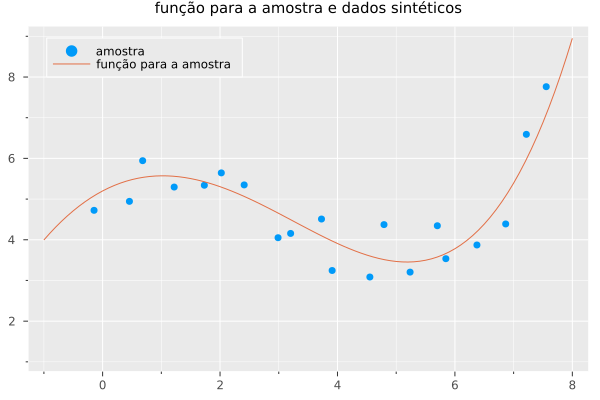

In [5]:
plot(xlim=(-1, 8), ylim=(1, 9), legend=:topleft,
    titlefont=10, title="função para a amostra e dados sintéticos")
plot!(dados_x, dados_y, seriestype=:scatter, label="amostra")
plot!(x, x -> f_dados(x, β̲), label="função para a amostra")

### Selecionando os dados de treino e de teste

In [6]:
indices  = shuffle(MersenneTwister(15041), 1:length(dados_x))
treino_x = dados_x[sort(indices[1:3*div(end,4)])]
treino_y = dados_y[sort(indices[1:3*div(end,4)])]
teste_x = dados_x[sort(indices[3*div(end,4)+1:end])]
teste_y = dados_y[sort(indices[3*div(end,4)+1:end])]
nothing

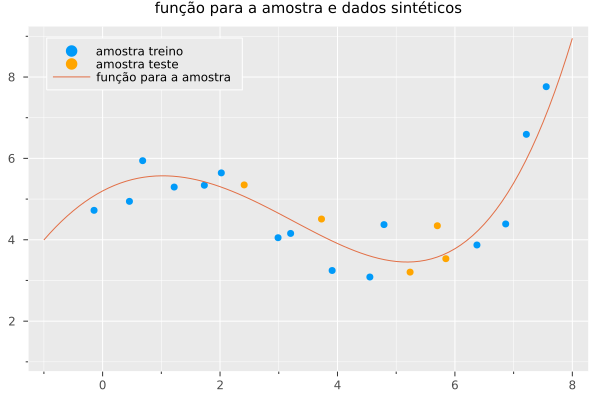

In [7]:
plot(xlim=(-1, 8), ylim=(1, 9), legend=:topleft,
    titlefont=10, title="função para a amostra e dados sintéticos")
plot!(treino_x, treino_y, seriestype=:scatter, label="amostra treino", color=1)
plot!(teste_x, teste_y, seriestype=:scatter, label="amostra teste", color=:orange)
plot!(x, x -> f_dados(x, β̲), label="função para a amostra", color=2)


### Modelo polinomial de grau baixo

* O modelo abaixo, após  o treino, apresentada um bom resultado no teste, com base no R quadrado.

In [8]:
A = reduce(hcat, [treino_x.^j for j=0:3])
β̂ = A \ treino_y
info_treino = info_ajuste(treino_x, treino_y, f_modelo.(treino_x, Ref(β̂)), length(β̂))
info_teste = info_ajuste(teste_x, teste_y, f_modelo.(teste_x, Ref(β̂)), length(β̂))
nothing

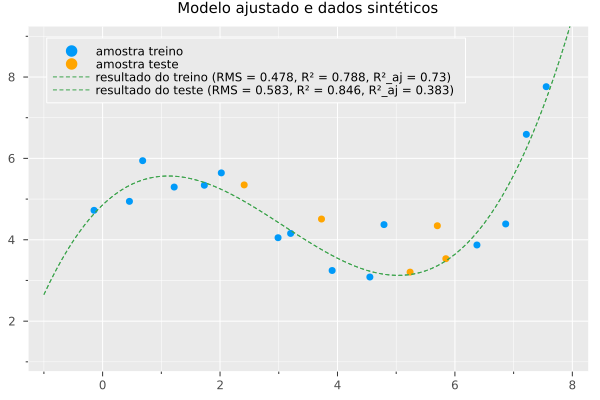

In [9]:
plot(xlim=(-1, 8), ylim=(1, 9), legend=:topleft,
    titlefont=10, title="Modelo ajustado e dados sintéticos")
plot!(treino_x, treino_y, seriestype=:scatter, label="amostra treino", color=1)
plot!(teste_x, teste_y, seriestype=:scatter, label="amostra teste", color=:orange)
plot!(x, x -> f_modelo(x, β̂),
    label="resultado do treino (RMS = $(round(info_treino.rms, digits = 3)), " * 
        "R² = $(round(info_treino.r_sq,digits=3)), " * 
        "R²_aj = $(round(info_treino.r_sq_aj,digits=3)))",
    linestyle=:dash)
plot!(x, x -> f_modelo(x, β̂),
    label="resultado do teste (RMS = $(round(info_teste.rms, digits = 3)), " *
        "R² = $(round(info_teste.r_sq,digits=3)), " *
        "R²_aj = $(round(info_teste.r_sq_aj,digits=3)))",
    color=3, linestyle=:dash)

### Modelo polinomial de grau alto

* O modelo abaixo, após  o treino, apresenta um resultado ruim no teste, com base no R-quadrado.

In [10]:
A = reduce(hcat, [treino_x.^j for j=0:12])
β̂ = A \ treino_y
info_treino = info_ajuste(treino_x, treino_y, f_modelo.(treino_x, Ref(β̂)), length(β̂))
info_teste = info_ajuste(teste_x, teste_y, f_modelo.(teste_x, Ref(β̂)), length(β̂))
nothing

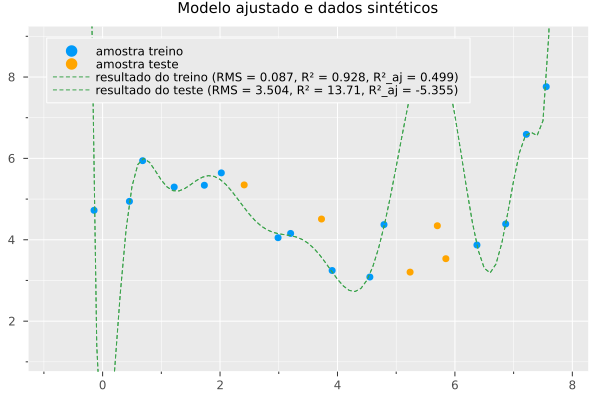

In [11]:
plot(xlim=(-1,8), ylim=(1,9), legend=:topleft,
    titlefont=10, title="Modelo ajustado e dados sintéticos")
plot!(treino_x, treino_y, seriestype=:scatter, label="amostra treino", color=1)
plot!(teste_x, teste_y, seriestype=:scatter, label="amostra teste", color=:orange)
plot!(x,x->f_modelo(x,β̂),
    label="resultado do treino (RMS = $(round(info_treino.rms, digits = 3)), " * 
        "R² = $(round(info_treino.r_sq,digits=3)), " * 
        "R²_aj = $(round(info_treino.r_sq_aj,digits=3)))",
    linestyle=:dash)
plot!(x,x->f_modelo(x,β̂),
    label="resultado do teste (RMS = $(round(info_teste.rms, digits = 3)), " *
        "R² = $(round(info_teste.r_sq,digits=3)), " *
        "R²_aj = $(round(info_teste.r_sq_aj,digits=3)))",
    color=3, linestyle=:dash)

* Observe, nesse caso, que, apesar de estarmos no contexto de regressão linear, o valor de R-quadrado *do teste* está totalmente fora do intervalo $0 \leq R^2 \leq 1$.

* Mas não é nenhuma contradição. O ajuste foi feito com os dados do treino e esse resultado vale apenas para o R-quadrado *do treino*.

* É mais um sinal de que o modelo fugiu do controle.

## Exercícios

1. Faça a validação cruzada das modelagens feitas nos exercícios do caderno 8, sobre **Modelos redutíveis ao caso linear nos parâmetros e aplicações**.

1. Faça a validação cruzada do modelos do exemplo sintético deste caderno.

1. Sobre o problema de modelagem de reação enzimática em fígados de porcos, também discutido no caderno 8, faça, ainda, a validação cruzada e a valiação cruzada com dobras de modelos polinomiais de diferentes ordens.